# Toxic Comment Classification Project

## Introduction
This project aims to build a multi-headed model in Python to identify various forms of toxicity in user comments, including insults, obscenity, threats, and identity-based hate. The dataset, derived from the Wiki corpus, includes labeled categories such as Insult, Identity Hate, Threat, Toxic, Obscene, and Severe Toxic.

## Objective
The goal is to accurately predict these toxicity categories for each comment using a model built without transformers or pre-trained LLMs.

## Technology and Tools Used
- Python
- Pandas and NumPy for data manipulation
- Matplotlib and Seaborn for data visualization
- NLTK and SpaCy for text processing
- TensorFlow and Keras for model building
- Jupyter Notebook for development

## Steps
1. **Data Loading and Exploration**
    - Load the training and test datasets.
    - Display the first few rows of the dataset to understand its structure.

2. **Data Understanding and Cleaning**
    - Check the structure of the dataset and summary statistics.
    - Identify and handle missing values.
    - Remove unnecessary columns and clean the text data.

3. **Text Preprocessing**
    - Remove stopwords using NLTK.
    - Apply lemmatization using SpaCy.
    - Remove HTML tags, links, special characters, digits, and multiple spaces.
    - Convert text to lowercase and apply the preprocessing function to the comment text.

4. **Exploratory Data Analysis (EDA)**
    - Visualize the distribution of toxicity categories.
    - Generate word clouds for different toxicity categories.

5. **Model Building**
    - Use TF-IDF Vectorizer for feature extraction.
    - Split the data into training and testing sets.
    - Build a multi-headed neural network using TensorFlow and Keras.
    - Compile and train the model.

6. **Model Evaluation**
    - Evaluate the model using classification metrics like precision, recall, and F1-score.
    - Generate a classification report.

7. **Saving and Exporting the Model**
    - Save the trained model for future use.
    - Export the preprocessed data for future data imports.

## Data Source
The data for this project is sourced from the [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview) on Kaggle.


# Step #1: Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
import spacy


# Load the data

In [2]:
# Load the datasets
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

# Display the first few rows of the train dataset
print("First few rows of the training data:")
display(train_data.head())

First few rows of the training data:


,id,comment_text,insult,identity_hate,threat,toxic,obscene,severe_toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Step #2: Understand the data

In [3]:
# Checking the structure of the dataset
print("\nDataset Information:")
train_data.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   insult         159571 non-null  int64 
 3   identity_hate  159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   toxic          159571 non-null  int64 
 6   obscene        159571 non-null  int64 
 7   severe_toxic   159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [4]:
# Summary statistics
print("\nSummary Statistics:")
display(train_data.describe())


Summary Statistics:


,insult,identity_hate,threat,toxic,obscene,severe_toxic
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.049364,0.008805,0.002996,0.095844,0.052948,0.009996
std,0.216627,0.093420,0.054650,0.294379,0.223931,0.099477
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Checking for missing values
print("\nMissing Values:")
display(train_data.isnull().sum())


Missing Values:


id               0
comment_text     0
insult           0
identity_hate    0
threat           0
toxic            0
obscene          0
severe_toxic     0
dtype: int64

# Step #3: Data Preparation

### Remove stopwords

In [6]:
# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')

# Get the list of stopwords
stop_words = set(stopwords.words('english'))

# Define a function to remove stopwords from a sentence
def remove_stopwords(sentence):
    tokens = sentence.split()  # Tokenize the sentence
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]  # Remove stopwords
    return ' '.join(filtered_tokens)  # Join the tokens back into a sentence

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mateuszskrycki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Lemmatization for better model accuracy

In [7]:
# Load a smaller and faster spaCy model
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])  # Disable NER and parser if not needed

# Define a function for batch processing with lemmatization
def batch_lemmatize(sentences):
    lemmatized_sentences = []
    for doc in nlp.pipe(sentences, batch_size=1000):  # Adjust batch_size as needed
        lemmatized_sentences.append(' '.join([token.lemma_ for token in doc]))
    return lemmatized_sentences


In [8]:
# Handling missing values
train_data = train_data.dropna()
test_data = test_data.dropna()

# Preprocess text data
def preprocess_text(text):
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove links (strings starting with http or www)
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters and digits
    text = text.replace("\n", " ")  # Replace newlines with space
    text = re.sub(r"[\u4e00-\u9fff]+", " ", text)  # Remove Chinese characters
    text = re.sub(r"\s+", " ", text).strip()  # Remove multiple spaces
    text = text.lower()  # Lowercase
    text = remove_stopwords(text)  # Remove stopwords
    return text

# Apply the preprocessing function to the comment text
train_data['comment_text'] = train_data['comment_text'].apply(preprocess_text)
test_data['comment_text'] = test_data['comment_text'].apply(preprocess_text)

In [9]:
# Apply batch lemmatization
train_data['comment_text'] = batch_lemmatize(train_data['comment_text'].tolist())
test_data['comment_text'] = batch_lemmatize(test_data['comment_text'].tolist())

In [10]:
# Verify the changes
print("\nPreprocessed Training Data:")
display(train_data.head())


Preprocessed Training Data:


,id,comment_text,insult,identity_hate,threat,toxic,obscene,severe_toxic
0,0000997932d777bf,explanation edit make username hardcore metall...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww match background colour I m seemingly stu...,0,0,0,0,0,0
2,000113f07ec002fd,hey man I m really try edit war guy constantly...,0,0,0,0,0,0
3,0001b41b1c6bb37e,can not make real suggestion improvement wonde...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page that s,0,0,0,0,0,0


In [11]:
# Verify the changes
print("\nPreprocessed Test Data:")
display(test_data.head())


Preprocessed Test Data:


,id,comment_text
0,00001cee341fdb12,yo bitch ja rule succesful you ll ever what s ...
1,0000247867823ef7,rfc title fine imo
2,00013b17ad220c46,source zawe ashton lapland
3,00017563c3f7919a,look back source information update correct fo...
4,00017695ad8997eb,do not anonymously edit article


### Export clean data (for future data imports)

In [12]:
# Save the preprocessed train_data to a CSV file (temporary)
train_data.to_csv('data_clean/train_preprocessed.csv', index=False)

# Verify that the file has been saved by loading it back and displaying the first few rows
saved_data = pd.read_csv('data_clean/train_preprocessed.csv')
print("\nSaved train_data preview:")
display(saved_data.head())


Saved train_data preview:


,id,comment_text,insult,identity_hate,threat,toxic,obscene,severe_toxic
0,0000997932d777bf,explanation edit make username hardcore metall...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww match background colour I m seemingly stu...,0,0,0,0,0,0
2,000113f07ec002fd,hey man I m really try edit war guy constantly...,0,0,0,0,0,0
3,0001b41b1c6bb37e,can not make real suggestion improvement wonde...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page that s,0,0,0,0,0,0


In [13]:
# Save the preprocessed test_data to a CSV file (temporary)
test_data.to_csv('data_clean/test_preprocessed.csv', index=False)

# Verify that the file has been saved by loading it back and displaying the first few rows
saved_data = pd.read_csv('data_clean/test_preprocessed.csv')
print("\nSaved train_data preview:")
display(saved_data.head())


Saved train_data preview:


,id,comment_text
0,00001cee341fdb12,yo bitch ja rule succesful you ll ever what s ...
1,0000247867823ef7,rfc title fine imo
2,00013b17ad220c46,source zawe ashton lapland
3,00017563c3f7919a,look back source information update correct fo...
4,00017695ad8997eb,do not anonymously edit article


# Step #4: Exploratory Data Analysis (EDA)

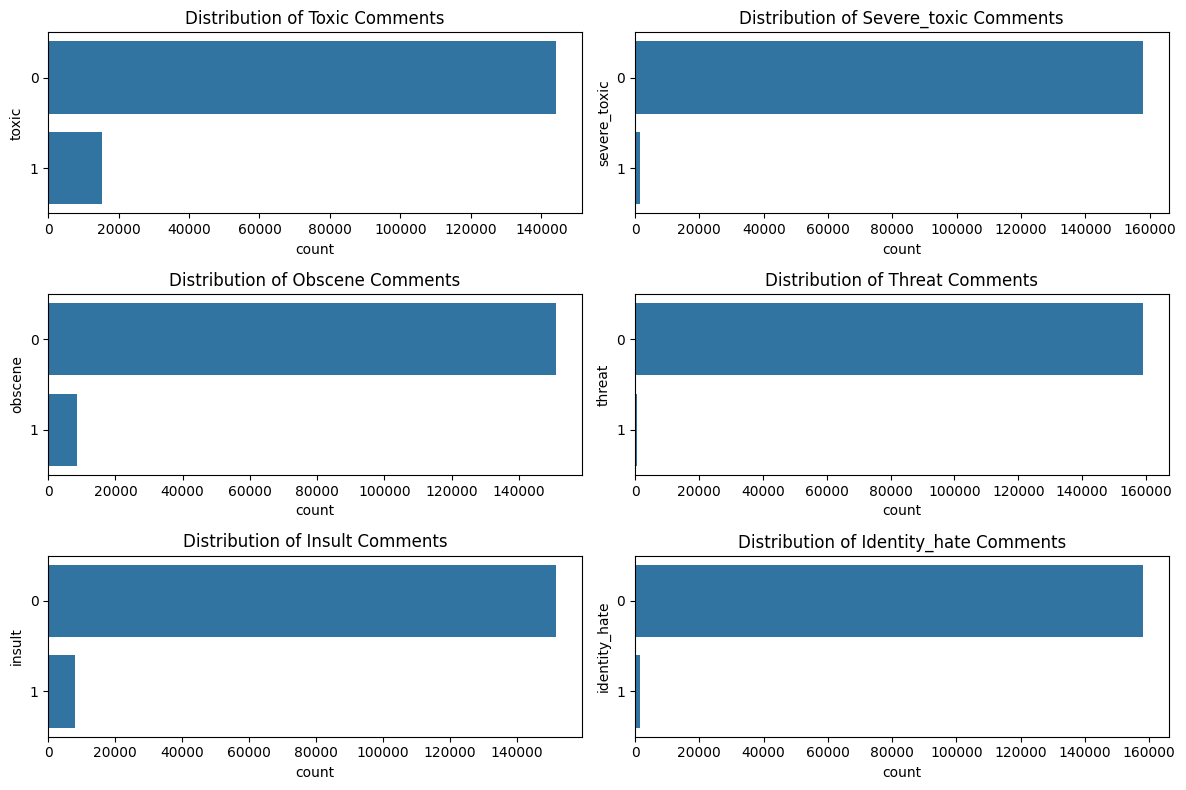

In [14]:
# Plotting the distribution of each toxicity class
toxicity_categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

plt.figure(figsize=(12, 8))
for i, category in enumerate(toxicity_categories):
    plt.subplot(3, 2, i + 1)
    sns.countplot(data=train_data, y=category, order=train_data[category].value_counts().index)
    plt.title(f'Distribution of {category.capitalize()} Comments')
plt.tight_layout()
plt.show()

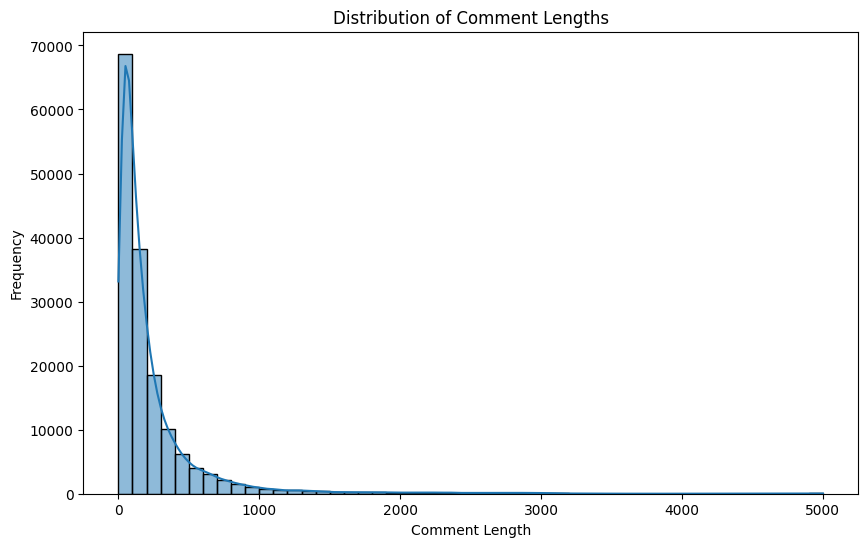

In [15]:
# Comment length distribution
train_data['comment_length'] = train_data['comment_text'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(train_data['comment_length'], bins=50, kde=True)
plt.title('Distribution of Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.show()

#### Interpretation of Comment Length Distribution

The histogram shows that most comments are relatively short, with a peak around 100 characters.

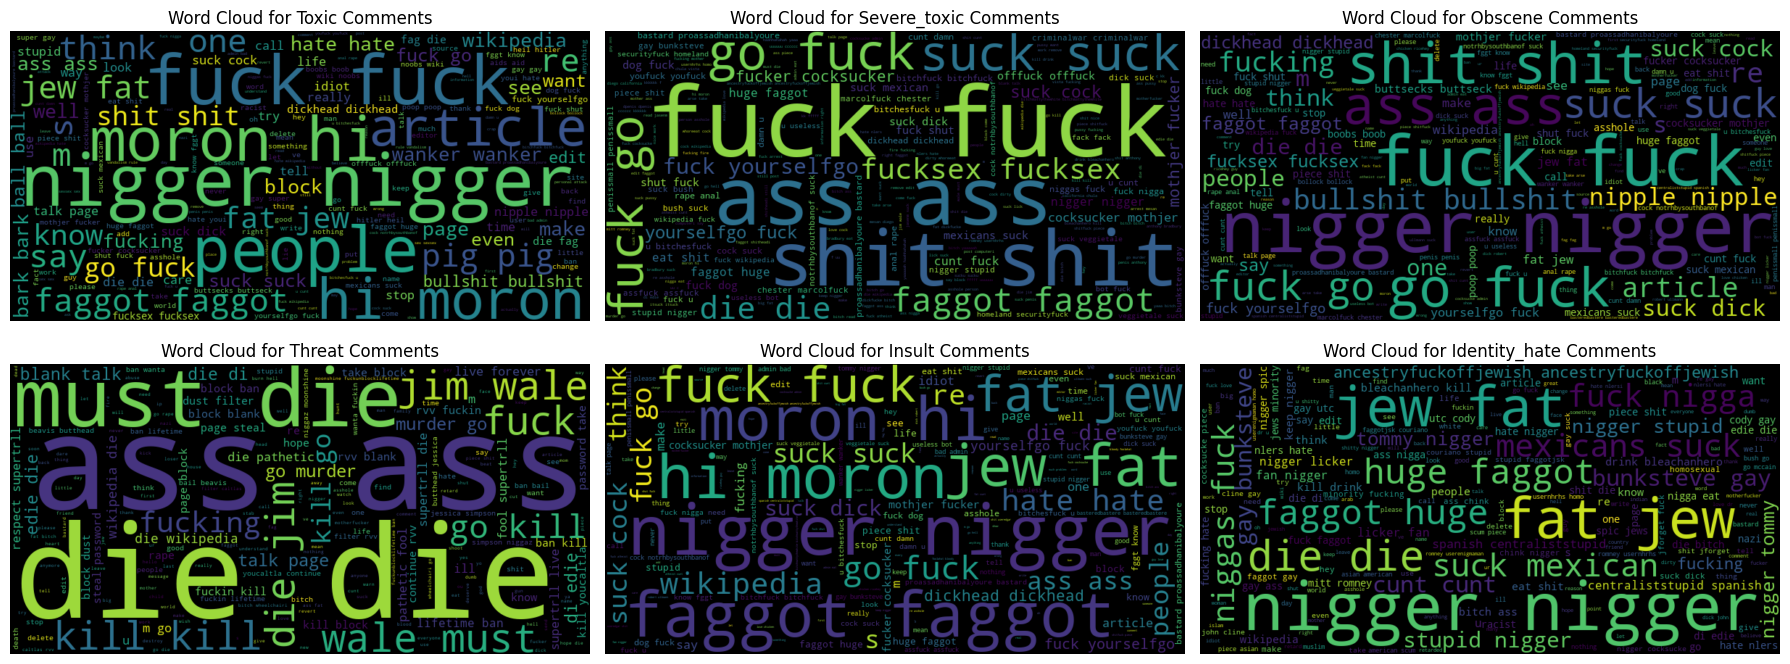

In [16]:
# Word cloud for toxic comments

# Number of categories
num_categories = len(toxicity_categories)

# Determine the grid size for subplots
nrows = 2
ncols = 3

# Create a figure and axes for subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 7))

# Generate and plot word clouds for each category
for i, category in enumerate(toxicity_categories):
    ax = axes[i // ncols, i % ncols]
    category_comments = ' '.join(train_data[train_data[category] == 1]['comment_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(category_comments)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'Word Cloud for {category.capitalize()} Comments')

# Adjust layout
plt.tight_layout()
plt.show()

#### Interpretation of Word Clouds

The word clouds highlight the most frequent words in each category of toxic comments, providing insight into common themes and language used in toxic comments.

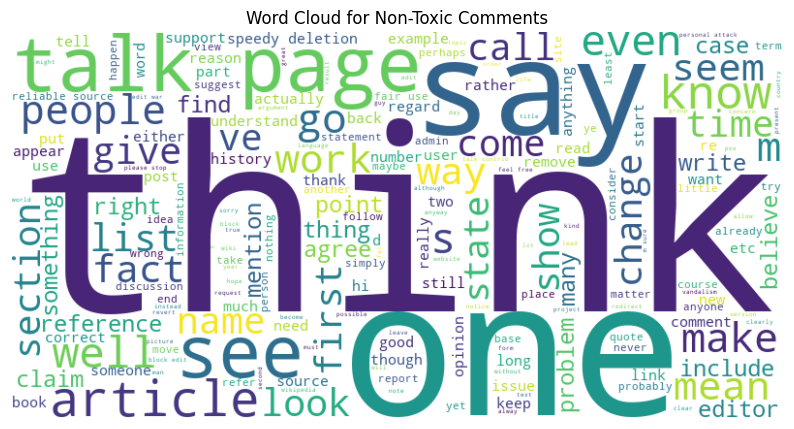

In [17]:
# Word cloud for non-toxic comments
non_toxic_comments = ' '.join(train_data[train_data['toxic'] == 0]['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(non_toxic_comments)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Non-Toxic Comments')
plt.show()

#### Interpretation of Non-Toxic Word Cloud

The word cloud for non-toxic comments shows a different set of frequent words, indicating the distinction in language between toxic and non-toxic comments.

# Step #5: Feature Extraction

In [18]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=10000)

# Fit and transform the train and test datasets
X_train_full = tfidf.fit_transform(train_data['comment_text'])
X_test = tfidf.transform(test_data['comment_text'])

# Extract the labels
y_train_full = train_data[toxicity_categories]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Convert sparse matrices to dense for Keras
X_train = X_train.toarray()
X_val = X_val.toarray()
X_test = X_test.toarray()

# Multi-headed Model Building

Explanation:

1. Input Layer: Takes the TF-IDF vectorized sequences of the comments.
2. Shared Dense Layers: Common dense layers that apply transformations to the input data and are shared by all output heads.
3. Output Heads: Each output head is a dense layer with a sigmoid activation function, responsible for predicting one of the toxicity labels.

In [19]:
# Define the input layer
input_layer = Input(shape=(X_train.shape[1],), name='input_layer')

# Shared dense layers
shared_dense = Dense(64, activation='relu')(input_layer)
shared_dense = Dense(32, activation='relu')(shared_dense)

# Define output heads
output_insult = Dense(1, activation='sigmoid', name='output_insult')(shared_dense)
output_identity_hate = Dense(1, activation='sigmoid', name='output_identity_hate')(shared_dense)
output_threat = Dense(1, activation='sigmoid', name='output_threat')(shared_dense)
output_toxic = Dense(1, activation='sigmoid', name='output_toxic')(shared_dense)
output_obscene = Dense(1, activation='sigmoid', name='output_obscene')(shared_dense)
output_severe_toxic = Dense(1, activation='sigmoid', name='output_severe_toxic')(shared_dense)

# Create the model
model = Model(inputs=input_layer, outputs=[
    output_insult, 
    output_identity_hate, 
    output_threat, 
    output_toxic, 
    output_obscene, 
    output_severe_toxic
])

In [20]:
# Compile the model
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics={
        'output_insult': ['accuracy'],
        'output_identity_hate': ['accuracy'],
        'output_threat': ['accuracy'],
        'output_toxic': ['accuracy'],
        'output_obscene': ['accuracy'],
        'output_severe_toxic': ['accuracy']
    }
)

# Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10000)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │    640,064 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_insult       │ (None, 1)         │         33 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_identity_ha… │ (None, 1)         │         33 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_threat       │ (None, 1)         │         33 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_toxic        │ (None, 1)         │         33 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_obscene      │ (None, 1)         │         33 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_severe_toxic │ (None, 1)         │         33 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 642,342 (2.45 MB)

 Trainable params: 642,342 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the model
model.fit(
    X_train,
    [
        y_train["insult"],
        y_train["identity_hate"],
        y_train["threat"],
        y_train["toxic"],
        y_train["obscene"],
        y_train["severe_toxic"],
    ],
    epochs=10,
    batch_size=32,
    validation_data=(
        X_val,
        [
            y_val["insult"],
            y_val["identity_hate"],
            y_val["threat"],
            y_val["toxic"],
            y_val["obscene"],
            y_val["severe_toxic"],
        ],
    ),
)

Epoch 1/10
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.6967 - output_identity_hate_accuracy: 0.9902 - output_insult_accuracy: 0.9310 - output_obscene_accuracy: 0.9641 - output_severe_toxic_accuracy: 0.9835 - output_threat_accuracy: 0.9944 - output_toxic_accuracy: 0.9371 - val_loss: 0.3262 - val_output_identity_hate_accuracy: 0.9912 - val_output_insult_accuracy: 0.9705 - val_output_obscene_accuracy: 0.9784 - val_output_severe_toxic_accuracy: 0.9900 - val_output_threat_accuracy: 0.9977 - val_output_toxic_accuracy: 0.9579
Epoch 2/10
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.2685 - output_identity_hate_accuracy: 0.9923 - output_insult_accuracy: 0.9744 - output_obscene_accuracy: 0.9824 - output_severe_toxic_accuracy: 0.9905 - output_threat_accuracy: 0.9968 - output_toxic_accuracy: 0.9636 - val_loss: 0.3287 - val_output_identity_hate_accuracy: 0.9919 - val_output_insult_accuracy: 0.9710 - val_output_obscene_accuracy: 0.9792 - val_output_severe_toxic_accuracy: 0.9905 - v

In [22]:
# Evaluate the model on the validation set
evaluation = model.evaluate(
    X_val, 
    [
        y_val["insult"], 
        y_val["identity_hate"], 
        y_val["threat"], 
        y_val["toxic"], 
        y_val["obscene"], 
        y_val["severe_toxic"]
    ]
)

# Print the evaluation results
print(f'\nEvaluation Results: {evaluation}')

# Extract the combined loss
combined_loss = evaluation[0]

# Extract the individual accuracies
individual_accuracies = evaluation[1:]

# Map the accuracies to their respective categories
accuracies_dict = {category: acc for category, acc in zip(toxicity_categories, individual_accuracies)}

# Print the combined loss
print(f'\nCombined Validation Loss: {combined_loss}')

998/998 ━━━━━━━━━━━━━━━━━━━━ 1s 638us/step - loss: 0.8825 - output_identity_hate_accuracy: 0.9912 - output_insult_accuracy: 0.9650 - output_obscene_accuracy: 0.9744 - output_severe_toxic_accuracy: 0.9889 - output_threat_accuracy: 0.9974 - output_toxic_accuracy: 0.9491

Evaluation Results: [0.8969308733940125, 0.9907566905021667, 0.9651888012886047, 0.973617434501648, 0.9890020489692688, 0.9973993301391602, 0.9483628273010254]

Combined Validation Loss: 0.8969308733940125


In [23]:
# Print the individual accuracies
for category, accuracy in accuracies_dict.items():
    print(f'Validation {category.capitalize()} Accuracy: {accuracy}')

Validation Toxic Accuracy: 0.9907566905021667
Validation Severe_toxic Accuracy: 0.9651888012886047
Validation Obscene Accuracy: 0.973617434501648
Validation Threat Accuracy: 0.9890020489692688
Validation Insult Accuracy: 0.9973993301391602
Validation Identity_hate Accuracy: 0.9483628273010254


# Step #6: Model Evaluation

In [24]:
# Make predictions on the validation set
y_pred = model.predict(X_val)

998/998 ━━━━━━━━━━━━━━━━━━━━ 1s 545us/step


In [25]:
# Experiment with different thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
for threshold in thresholds:
    print(f"\nClassification Report with threshold {threshold}:")
    for i, category in enumerate(toxicity_categories):
        y_pred_binary = (y_pred[i] > threshold).astype(int)
        print(f"\nCategory: {category}")
        print(classification_report(y_val[category], y_pred_binary))
    print('------------------------------------------------------------')



Classification Report with threshold 0.1:

Category: toxic
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     28859
           1       0.82      0.54      0.65      3056

    accuracy                           0.94     31915
   macro avg       0.89      0.76      0.81     31915
weighted avg       0.94      0.94      0.94     31915


Category: severe_toxic
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     31594
           1       0.22      0.26      0.24       321

    accuracy                           0.98     31915
   macro avg       0.61      0.63      0.62     31915
weighted avg       0.98      0.98      0.98     31915


Category: obscene
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     30200
           1       0.55      0.04      0.07      1715

    accuracy                           0.95     31915
   macro avg       0.75  

### Best Threshold Decision
Based on the metrics:

<li>Threshold 0.1 shows better recall for threat, identity_hate, and insult, but low precision.
<li>Threshold 0.2 seems to balance precision and recall better, especially for toxic, severe_toxic, and insult.
<li>Threshold 0.3 onwards, precision increases but recall drops significantly.

Based on these observations, threshold 0.2 offers a good balance between precision and recall across most categories, making it a suitable choice.

In [26]:
# Choosing a threshold based on the analysis above
chosen_threshold = 0.2
y_pred_binary = [(pred > chosen_threshold).astype(int) for pred in y_pred]

In [27]:
# Final classification report
print("\nFinal Classification Report with chosen threshold:")
for i, category in enumerate(toxicity_categories):
    print(f"\nCategory: {category}")
    print(classification_report(y_val[category], y_pred_binary[i]))


Final Classification Report with chosen threshold:

Category: toxic
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     28859
           1       0.85      0.51      0.63      3056

    accuracy                           0.94     31915
   macro avg       0.90      0.75      0.80     31915
weighted avg       0.94      0.94      0.94     31915


Category: severe_toxic
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     31594
           1       0.24      0.22      0.23       321

    accuracy                           0.99     31915
   macro avg       0.61      0.61      0.61     31915
weighted avg       0.98      0.99      0.98     31915


Category: obscene
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     30200
           1       0.54      0.03      0.05      1715

    accuracy                           0.95     31915
   macro avg    

# Step #7: Predictions on Test Data

In [28]:
# Predictions on Test Data
test_pred = model.predict(X_test)
test_pred_binary = [(pred > chosen_threshold).astype(int) for pred in test_pred]

# Create a DataFrame for the test predictions
test_predictions = pd.DataFrame(np.column_stack(test_pred_binary), columns=toxicity_categories)

# Add 'id' and 'comment_text' columns
test_predictions['id'] = test_data['id']
test_predictions['comment_text'] = test_data['comment_text']

# Reorder the columns to have 'id' and 'comment_text' first
test_predictions = test_predictions[['id', 'comment_text'] + toxicity_categories]

# Save the test predictions to a CSV file
test_predictions.to_csv('output/test_predictions.csv', index=False)
print("Test predictions have been saved to 'output/test_predictions.csv'")

4787/4787 ━━━━━━━━━━━━━━━━━━━━ 3s 537us/step
Test predictions have been saved to 'output/test_predictions.csv'


# Model Interpretation

#### Shared Dense Layers:
- These layers extract common patterns from the input data (TF-IDF vectors of comments). They learn to capture general features related to various forms of toxicity.

#### Output Heads:
- Each output head corresponds to a specific toxicity category: insult, identity_hate, threat, toxic, obscene, severe_toxic.
- The final dense layer in each head applies the learned weights to generate a probability score for the associated category.

#### Feature Contributions:
- The TF-IDF vectorization process transforms comments into numerical features based on word importance.
- Higher weights in the dense layers indicate a stronger influence of certain words or phrases on the predictions for each toxicity category. For example, words commonly associated with offensive language will have higher weights in the 'insult' and 'obscene' categories.

#### Thresholds for Classification:
- The output probabilities are converted into binary classifications (toxic or non-toxic) using a chosen threshold (e.g., 0.2). This threshold balances precision and recall for each category.

#### Coefficients in Details:
- **Predictions:** The model uses the learned weights (coefficients) in the dense layers to calculate the probability of each comment being toxic in various ways.
- **Interpretation:** Although individual weights are complex to interpret directly, their collective influence shapes the model’s ability to identify toxic language. Higher coefficients for specific words in the TF-IDF vectors indicate stronger contributions to toxicity predictions.


# Step #8: Summary and Conclusion

In [29]:
print("1. Data was vectorized using TF-IDF.")
print("2. A multi-headed model was trained to predict different forms of toxicity.")
print("3. Various thresholds were tested to find the best threshold for binary classification.")
print(f"4. A threshold of {chosen_threshold} was chosen based on a balance between precision and recall.")
print("5. Final predictions were made on the test data, and the results were saved to 'output/test_predictions.csv'.")
print("6. This model helps in identifying various forms of toxicity in comments effectively.")



Summary and Conclusion:
1. Data was vectorized using TF-IDF.
2. A multi-headed model was trained to predict different forms of toxicity.
3. Various thresholds were tested to find the best threshold for binary classification.
4. A threshold of 0.2 was chosen based on a balance between precision and recall.
5. Final predictions were made on the test data, and the results were saved to 'output/test_predictions.csv'.
6. This model helps in identifying various forms of toxicity in comments effectively.
